In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

base_path = "/content/drive/MyDrive/ML_Projects/plant-leaf-disease-classification"
os.listdir(base_path)


['plantvillage dataset', 'data']

In [4]:
import os
import shutil
import random

PROJECT_PATH = "/content/drive/MyDrive/ML_Projects/plant-leaf-disease-classification"
RAW_DATASET_PATH = PROJECT_PATH + "/plantvillage dataset"
TARGET_PATH = PROJECT_PATH + "/data"


In [5]:
SOURCE_FOLDERS = {
    "Tomato___healthy": "Healthy",
    "Tomato___Early_blight": "Early_Blight",
    "Tomato___Late_blight": "Late_Blight",
    "Tomato___Leaf_Mold": "Leaf_Mold"
}

MAX_IMAGES_PER_CLASS = 150


In [6]:
for cls in SOURCE_FOLDERS.values():
    os.makedirs(os.path.join(TARGET_PATH, cls), exist_ok=True)


In [7]:
for src, tgt in SOURCE_FOLDERS.items():
    src_path = os.path.join(RAW_DATASET_PATH, src)
    tgt_path = os.path.join(TARGET_PATH, tgt)

    images = os.listdir(src_path)
    random.shuffle(images)
    images = images[:MAX_IMAGES_PER_CLASS]

    for img in images:
        shutil.copy(
            os.path.join(src_path, img),
            os.path.join(tgt_path, img)
        )

print("Tomato dataset organized successfully.")


Tomato dataset organized successfully.


In [8]:
for cls in os.listdir(TARGET_PATH):
    print(cls, ":", len(os.listdir(os.path.join(TARGET_PATH, cls))))


Healthy : 279
Early_Blight : 276
Late_Blight : 286
Leaf_Mold : 278


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [10]:
IMG_SIZE = (224, 224)   # MobileNetV2 expects this
BATCH_SIZE = 16
DATA_PATH = "/content/drive/MyDrive/ML_Projects/plant-leaf-disease-classification/data"


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 1119 files belonging to 4 classes.
Using 896 files for training.
Found 1119 files belonging to 4 classes.
Using 223 files for validation.


In [12]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


In [14]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(4, activation="softmax")
])


In [16]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
for images, labels in train_ds.take(1):
    model(images)


In [18]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (16, 7, 7, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (16, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 128)              │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5596 - loss: 1.0293 - val_accuracy: 0.8251 - val_loss: 0.4712
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8726 - loss: 0.3860 - val_accuracy: 0.7937 - val_loss: 0.5057
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 978ms/step - accuracy: 0.8757 - loss: 0.3411 - val_accuracy: 0.8744 - val_loss: 0.3138
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9155 - loss: 0.2399 - val_accuracy: 0.8789 - val_loss: 0.3995
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9275 - loss: 0.2264 - val_accuracy: 0.8565 - val_loss: 0.4168
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9344 - loss: 0.2108 - val_accuracy: 0.8610 - val_loss: 0.3769
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 972ms/step - accuracy: 0.9392 - loss: 0.1665 - val_accuracy: 0.8655 - val_loss: 0.3921
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9305 - loss: 0.1837 - val_accuracy: 0.8341 - val

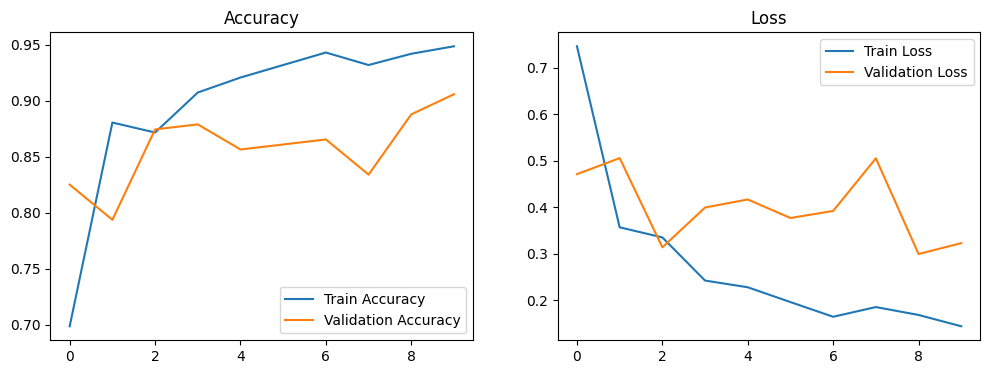

In [20]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [23]:
class_names = [
    "Healthy",
    "Early_Blight",
    "Late_Blight",
    "Leaf_Mold"
]



print(class_names)


['Healthy', 'Early_Blight', 'Late_Blight', 'Leaf_Mold']


In [24]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: Leaf_Mold


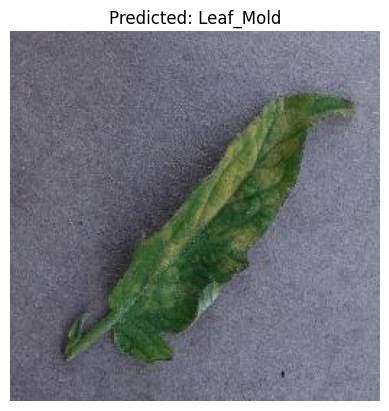

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# Choose any image from a class folder
test_class = "Leaf_Mold"
test_image = os.listdir(os.path.join(DATA_PATH, test_class))[0]
img_path = os.path.join(DATA_PATH, test_class, test_image)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]


print("Predicted:", predicted_class)

plt.imshow(Image.open(img_path))
plt.axis("off")
plt.title(f"Predicted: {predicted_class}")
plt.show()
